In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms, models
import torch
from PIL import Image
import numpy as np

import os
from datetime import datetime
import matplotlib.pyplot as plt

import math
import shutil
from google.colab import drive
from PIL import Image

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [3]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Konstantos**


1.   ```LOAD_CHECKPOINT``` - switch to True to load existing checkpoint from path
2.   ```USE_SUBSET``` - switch to True to use a part of dataset (useful for testing purposes)
3. ```TRAIN_SUBSET_SIZE``` - define size of train part of dataset
4. ```VALID_SUBSET_SIZE``` - define a size of test part of dataset

**WARNING!!! IMPORTANT!!!**


1.   Jei norite bandyti trainint (patestuot) ir nežinote ar gerai bus, geriausia pakeiskite ```CHECKPOINT_FILENAME``` į kokį nors kitą, kad neprarastume rezultatus. ```checkpoint_poultry``` checkpointa naudokime kaip final versiją.



In [27]:
FEATURE_EXTRACTION = True
CLASS_LIST = ["healthy", "salmo", "cocci", "ncd"]
CLASS_INDICES = {'healthy': 0, 'salmo': 1, 'cocci': 2, 'ncd': 3}
EPOCH_COUNT = 20
TO_RECOGNIZE = 5

TRAIN_PART = 0.8
LEARNING_RATE = 1e-3
PATIENCE = 7

LOAD_CHECKPOINT = False
ROOT_DIR = "/content/drive/MyDrive/project"
CHECKPOINT_FILENAME = "/content/drive/MyDrive/project/checkpoint_poultry.tar"

USE_SUBSET = False
TRAIN_SUBSET_SIZE = 50 * len(CLASS_LIST)
VALID_SUBSET_SIZE = 15 * len(CLASS_LIST)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cuda:0


**Some helper functions**

In [5]:
def seconds_to_time(seconds):
    s = int(seconds) % 60
    m = int(seconds) // 60
    if m < 1:
        return f'{s}s'
    h = m // 60
    m = m % 60
    if h < 1:
        return f'{m}m{s}s'
    return f'{h}h{m}m{s}s'

In [6]:
def load_checkpoint(filename, model, optimizer):
    print("Loading checkpoint...")
    checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])

    training_history = {
        "epoch": checkpoint.get("epoch", 0),
        "train_loss_history": checkpoint.get("train_loss_history", []),
        "accuracy_history": checkpoint.get("accuracy_history", []),
        "train_accuracy_history": checkpoint.get("train_accuracy_history", []),
        "val_loss_history": checkpoint.get("val_loss_history", []),
        "precision_history": checkpoint.get("precision_history", []),
        "recall_history": checkpoint.get("recall_history", []),
        "f1_score_history": checkpoint.get("f1_score_history", []),
        "stats_history": checkpoint.get("stats_history", []),
        "conf_matrix": checkpoint.get("conf_matrix", [])
    }

    return training_history

**Early stopping**

In [7]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_score = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

**Vištų šūdukų datasetas paruoštas klasifikavimo uždaviniui**

In [28]:
class PoultryDatasetClassification(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return image, label

def create_datasets(root_dir, data_classes, test_size=0.2, random_state=42):
    image_paths = []
    labels = []
    class_indices = {data_class: i for i, data_class in enumerate(data_classes)}

    for data_class in data_classes:
        images_dir = os.path.join(root_dir, data_class, data_class)
        if not os.path.exists(images_dir):
            print(f"Directory does not exist: {images_dir}")
            continue

        for img in os.listdir(images_dir):
            if img.endswith(".jpg"):
                image_paths.append(os.path.join(images_dir, img))
                label = [0] * len(data_classes)
                label[class_indices[data_class]] = 1
                labels.append(label)

    # Split data while keeping the distribution of classes consistent
    img_train, img_test, labels_train, labels_test = train_test_split(
        image_paths, labels, test_size=test_size, random_state=random_state, stratify=labels
    )

    # Applying transformations
    transform_train = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    transform_test = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Creating dataset objects for training and testing
    train_dataset = PoultryDatasetClassification(img_train, labels_train, transform=transform_train)
    test_dataset = PoultryDatasetClassification(img_test, labels_test, transform=transform_test)

    return train_dataset, test_dataset


In [9]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()

    running_train_loss = np.array([], dtype=np.float32)
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels_as_indices = torch.argmax(labels, dim=1)

        outputs = model(images)

        loss = criterion(outputs, labels_as_indices)
        running_train_loss = np.append(running_train_loss, loss.cpu().detach().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.argmax(outputs, axis = 1)
        correct_predictions += (predicted == labels_as_indices).sum().item()
        total_predictions += labels_as_indices.size(0)

    train_loss = np.mean(running_train_loss)
    train_accuracy = correct_predictions / total_predictions

    return train_loss, train_accuracy

**Skaičiuojamos metrikos visiems predictionams**

In [16]:
def calculate_metrics(correct_predictions, total_predictions, y_true, y_pred):
    print('Total predictions: ', total_predictions)
    print('Correct predictions: ', correct_predictions)

    accuracy = correct_predictions / total_predictions
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, conf_matrix

**Skaičiuojamos metrikos kiekvienai klasei su pasirinktu threshold**

In [10]:
def calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.8):
    num_classes = all_true_labels.shape[1]
    stats = {}
    for class_index in range(num_classes):
        predictions = (all_confidences[:, class_index] >= threshold).astype(int)

        true_labels = all_true_labels[:, class_index].astype(int)

        TP = np.sum((predictions == 1) & (true_labels == 1))
        TN = np.sum((predictions == 0) & (true_labels == 0))
        FP = np.sum((predictions == 1) & (true_labels == 0))
        FN = np.sum((predictions == 0) & (true_labels == 1))

        accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        stats[class_index] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score
        }

    return stats

**Evaluation loop'as**

In [11]:
def evaluate_epoch(model, test_loader, criterion, optimizer):
    model.eval()
    running_val_loss = np.array([], dtype = np.float32)
    correct_predictions, total_predictions = 0, 0
    y_true, y_pred, all_confidences, all_true_labels = [], [], [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels_as_indices = torch.argmax(labels, axis=1).to(device)

            outputs = model(images)

            confidences = torch.sigmoid(outputs)

            val_loss = criterion(outputs, labels_as_indices)
            running_val_loss = np.append(running_val_loss, val_loss.cpu().detach().numpy())

            predicted = torch.argmax(outputs, axis = 1)

            correct_predictions += (predicted == labels_as_indices).sum().item()
            total_predictions += labels_as_indices.size(0)

            y_true.extend(labels_as_indices.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            all_confidences.extend(confidences.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())

    all_confidences = np.array(all_confidences)
    all_true_labels = np.array(all_true_labels)

    stats = calculate_metrics_per_class(all_confidences, all_true_labels, threshold=0.5)

    for class_index, class_stats in stats.items():
        print(f"Class {class_index}:")
        print(f" Accuracy: {class_stats['accuracy']}")
        print(f" Precision: {class_stats['precision']}")
        print(f" Recall: {class_stats['recall']}")
        print(f" F1 Score: {class_stats['f1_score']}")

    return np.mean(running_val_loss), correct_predictions, total_predictions, y_true, y_pred, stats

**Pagrindnis loop'as, išsaugom istoriją kad ateityje būtų galima nubraižyt fancy grafikelius**

In [12]:
def train_and_eval(model, loader_train, loader_valid, filename, epoch_count, lr):
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = optim.Adam([
      {'params': model.resnet50.parameters(), 'lr': lr * 0.1},
      {'params': model.dense1.parameters(), 'lr': lr},
      {'params': model.dropout.parameters(), 'lr': lr},
      {'params': model.dense2.parameters(), 'lr': lr}
  ])
  early_stopping = EarlyStopping(patience=PATIENCE, min_delta=0.01)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=PATIENCE, verbose=True)
  start_time = datetime.now()

  training_history = None

  if LOAD_CHECKPOINT:
      training_history = load_checkpoint(filename, model, optimizer)
      start_epoch = training_history['epoch'] + 1
      train_loss_history = training_history['train_loss_history']
      accuracy_history = training_history['accuracy_history']
      train_accuracy_history = training_history['train_accuracy_history']
      val_loss_history = training_history['val_loss_history']
      precision_history = training_history['precision_history']
      recall_history = training_history['recall_history']
      f1_score_history = training_history['f1_score_history']
      stats_history = training_history['stats_history']
      conf_matrix = training_history['conf_matrix']
  else:
      start_epoch = 0
      train_loss_history = []
      val_loss_history = []
      accuracy_history = []
      train_accuracy_history = []
      precision_history = []
      recall_history = []
      f1_score_history = []
      stats_history = []
      conf_matrix = []

  for epoch in range(start_epoch, epoch_count):
      print('Starting training epoch... ', epoch)
      start_time = datetime.now()

      train_loss, train_accuracy = train_epoch(model, loader_train, loss_func, optimizer)

      current_time = datetime.now()
      elapsed = seconds_to_time((current_time - start_time).total_seconds())
      print(f'Epoch: {epoch}, Time: {elapsed}, Loss: {train_loss}')

      print('Starting evaluation... ', start_time)
      start_time = datetime.now()

      avg_val_loss, correct_predictions, total_predictions, y_true, y_pred, stats = evaluate_epoch(model, test_loader, loss_func, optimizer)

      accuracy, precision, recall, f1, conf_matrix = calculate_metrics(correct_predictions, total_predictions, y_true, y_pred)

      current_time = datetime.now()
      per_image = (current_time - start_time).total_seconds() / total_predictions
      print(f'Time: {per_image * 1000}ms, Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 score: {f1:.4f}')
      print(f'Confusion matrix: {conf_matrix}')

      accuracy_history.append(accuracy)
      train_accuracy_history.append(train_accuracy)
      train_loss_history.append(train_loss)
      val_loss_history.append(avg_val_loss)
      precision_history.append(precision)
      recall_history.append(recall)
      f1_score_history.append(f1)
      stats_history.append(stats)

      print("Saving checkpoint...")
      checkpoint = {
          "epoch": epoch,
          "state_dict": model.state_dict(),
          "optimizer": optimizer.state_dict(),
          "train_loss_history": train_loss_history,
          "accuracy_history": accuracy_history,
          "train_accuracy_history": train_accuracy_history,
          "val_loss_history": val_loss_history,
          "precision_history": precision_history,
          "recall_history": recall_history,
          "f1_score_history": f1_score_history,
          "stats_history": stats_history,
          "conf_matrix": conf_matrix
      }
      torch.save(checkpoint, filename)

      scheduler.step(avg_val_loss)

      early_stopping(avg_val_loss)
      if early_stopping.early_stop:
          print("Early stopping triggered. Reducing learning rate and resetting early stopping.")
          early_stopping.counter = 0

  return training_history


In [29]:
train_dataset, test_dataset = create_datasets(ROOT_DIR, CLASS_LIST)

if USE_SUBSET:
  train_dataset = Subset(train_dataset, range(TRAIN_SUBSET_SIZE))
  test_dataset = Subset(test_dataset, range(VALID_SUBSET_SIZE))

print(f'Train: {len(train_dataset)}, Test: {len(test_dataset)}')

num_workers = 2
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, num_workers = num_workers, shuffle = False)

Train: 5449, Test: 1363


**ResNet50 model modification**

In [30]:
class PoultryDiseaseClassifier(nn.Module):
    def __init__(self):
        super(PoultryDiseaseClassifier, self).__init__()
        self.resnet50 = resnet50
        self.flatten = nn.Flatten()
        self.dense1 = nn.Linear(num_ftrs, 256)
        self.dropout = nn.Dropout(0.3)
        self.dense2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.resnet50(x)
        x = self.flatten(x)
        x = F.relu(self.dense1(x))
        x = self.dropout(x)
        x = self.dense2(x)
        return x

**Užfreezinti visi parametrai išskyrus paskutinį sluoksnį**

In [ ]:
filename = CHECKPOINT_FILENAME

resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Identity()

model = PoultryDiseaseClassifier()
model.to(device)

print(f'Parameter count: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')
training_history = train_and_eval(model, train_loader, test_loader, filename, epoch_count = EPOCH_COUNT, lr = LEARNING_RATE)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Parameter count: 24,033,604
Starting training epoch...  0


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 0, Time: 13m43s, Loss: 0.21325339376926422
Starting evaluation...  2024-05-17 12:36:45.779412
Class 0:
 Accuracy: 0.9728539985326485
 Precision: 0.9213483146067416
 Recall: 0.9951456310679612
 F1 Score: 0.9568261376896149
Class 1:
 Accuracy: 0.8422597212032281
 Precision: 0.6796407185628742
 Recall: 0.9978021978021978
 F1 Score: 0.8085485307212823
Class 2:
 Accuracy: 0.9911958914159942
 Precision: 0.9722863741339491
 Recall: 1.0
 F1 Score: 0.9859484777517564
Class 3:
 Accuracy: 0.9728539985326485
 Precision: 0.6792452830188679
 Recall: 0.96
 F1 Score: 0.7955801104972376
Total predictions:  1363
Correct predictions:  1332
Time: 133.1989420396185ms, Epoch 0, Train Loss: 0.2133, Val Loss: 0.0649, Accuracy: 0.9773, Precision: 0.9776, Recall: 0.9773, F1 score: 0.9773
Confusion matrix: [[394  10   1   7]
 [  1 451   2   1]
 [  0   1 419   1]
 [  1   3   3  68]]
Saving checkpoint...
Starting training epoch...  1


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1, Time: 6m6s, Loss: 0.07865152508020401
Starting evaluation...  2024-05-17 12:53:32.894772
Class 0:
 Accuracy: 0.9383712399119589
 Precision: 0.8306451612903226
 Recall: 1.0
 F1 Score: 0.907488986784141
Class 1:
 Accuracy: 0.9126925898752751
 Precision: 0.7937062937062938
 Recall: 0.9978021978021978
 F1 Score: 0.8841285296981499
Class 2:
 Accuracy: 0.9977989728539985
 Precision: 0.995260663507109
 Recall: 0.997624703087886
 F1 Score: 0.9964412811387899
Class 3:
 Accuracy: 0.9911958914159942
 Precision: 0.8705882352941177
 Recall: 0.9866666666666667
 F1 Score: 0.925
Total predictions:  1363
Correct predictions:  1339
Time: 65.8494497432135ms, Epoch 1, Train Loss: 0.0787, Val Loss: 0.0474, Accuracy: 0.9824, Precision: 0.9824, Recall: 0.9824, F1 score: 0.9824
Confusion matrix: [[404   6   0   2]
 [  5 449   0   1]
 [  1   1 418   1]
 [  6   1   0  68]]
Saving checkpoint...
Starting training epoch...  2


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 2, Time: 6m12s, Loss: 0.06483273208141327
Starting evaluation...  2024-05-17 13:01:10.531790
Class 0:
 Accuracy: 0.9662509170946442
 Precision: 0.9030837004405287
 Recall: 0.9951456310679612
 F1 Score: 0.9468822170900694
Class 1:
 Accuracy: 0.966984592809978
 Precision: 0.9166666666666666
 Recall: 0.9912087912087912
 F1 Score: 0.9524815205913412
Class 2:
 Accuracy: 0.9970652971386648
 Precision: 1.0
 Recall: 0.9904988123515439
 F1 Score: 0.9952267303102625
Class 3:
 Accuracy: 0.9383712399119589
 Precision: 0.4716981132075472
 Recall: 1.0
 F1 Score: 0.641025641025641
Total predictions:  1363
Correct predictions:  1327
Time: 65.86547028613353ms, Epoch 2, Train Loss: 0.0648, Val Loss: 0.0872, Accuracy: 0.9736, Precision: 0.9791, Recall: 0.9736, F1 score: 0.9750
Confusion matrix: [[394   5   0  13]
 [  2 445   0   8]
 [  0   1 413   7]
 [  0   0   0  75]]
Saving checkpoint...
Starting training epoch...  3


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 3, Time: 6m9s, Loss: 0.0621151402592659
Starting evaluation...  2024-05-17 13:08:53.822828
Class 0:
 Accuracy: 0.9684519442406456
 Precision: 0.9054945054945055
 Recall: 1.0
 F1 Score: 0.95040369088812
Class 1:
 Accuracy: 0.962582538517975
 Precision: 0.8992094861660079
 Recall: 1.0
 F1 Score: 0.9469302809573362
Class 2:
 Accuracy: 0.9985326485693323
 Precision: 1.0
 Recall: 0.995249406175772
 F1 Score: 0.9976190476190476
Class 3:
 Accuracy: 0.9838591342626559
 Precision: 0.7789473684210526
 Recall: 0.9866666666666667
 F1 Score: 0.8705882352941177
Total predictions:  1363
Correct predictions:  1336
Time: 67.3429611151871ms, Epoch 3, Train Loss: 0.0621, Val Loss: 0.0560, Accuracy: 0.9802, Precision: 0.9812, Recall: 0.9802, F1 score: 0.9804
Confusion matrix: [[397   7   0   8]
 [  3 450   0   2]
 [  1   4 415   1]
 [  0   1   0  74]]
Saving checkpoint...
Starting training epoch...  4


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 4, Time: 6m16s, Loss: 0.0526769757270813
Starting evaluation...  2024-05-17 13:16:36.733903
Class 0:
 Accuracy: 0.9684519442406456
 Precision: 0.9054945054945055
 Recall: 1.0
 F1 Score: 0.95040369088812
Class 1:
 Accuracy: 0.9508437270726339
 Precision: 0.8745173745173745
 Recall: 0.9956043956043956
 F1 Score: 0.9311408016443988
Class 2:
 Accuracy: 0.9992663242846662
 Precision: 0.9976303317535545
 Recall: 1.0
 F1 Score: 0.9988137603795968
Class 3:
 Accuracy: 0.9963316214233309
 Precision: 0.9487179487179487
 Recall: 0.9866666666666667
 F1 Score: 0.9673202614379085
Total predictions:  1363
Correct predictions:  1346
Time: 67.0797131327953ms, Epoch 4, Train Loss: 0.0527, Val Loss: 0.0435, Accuracy: 0.9875, Precision: 0.9877, Recall: 0.9875, F1 score: 0.9875
Confusion matrix: [[403   9   0   0]
 [  1 452   0   2]
 [  0   3 418   0]
 [  2   0   0  73]]
Saving checkpoint...
Starting training epoch...  5


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 5, Time: 6m12s, Loss: 0.034292757511138916
Starting evaluation...  2024-05-17 13:24:26.068850
Class 0:
 Accuracy: 0.9867938371239912
 Precision: 0.9624413145539906
 Recall: 0.9951456310679612
 F1 Score: 0.9785202863961814
Class 1:
 Accuracy: 0.9728539985326485
 Precision: 0.9282786885245902
 Recall: 0.9956043956043956
 F1 Score: 0.960763520678685
Class 2:
 Accuracy: 0.9985326485693323
 Precision: 0.9952718676122931
 Recall: 1.0
 F1 Score: 0.9976303317535545
Class 3:
 Accuracy: 0.9933969185619956
 Precision: 0.9125
 Recall: 0.9733333333333334
 F1 Score: 0.9419354838709678
Total predictions:  1363
Correct predictions:  1346
Time: 65.99856713132796ms, Epoch 5, Train Loss: 0.0343, Val Loss: 0.0429, Accuracy: 0.9875, Precision: 0.9876, Recall: 0.9875, F1 score: 0.9875
Confusion matrix: [[404   7   0   1]
 [  4 450   0   1]
 [  0   1 420   0]
 [  1   2   0  72]]
Saving checkpoint...
Starting training epoch...  6


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 6, Time: 6m10s, Loss: 0.0362200103700161
Starting evaluation...  2024-05-17 13:32:09.727629
Class 0:
 Accuracy: 0.9779897285399853
 Precision: 0.9340909090909091
 Recall: 0.9975728155339806
 F1 Score: 0.9647887323943661
Class 1:
 Accuracy: 0.9838591342626559
 Precision: 0.9596602972399151
 Recall: 0.9934065934065934
 F1 Score: 0.9762419006479481
Class 2:
 Accuracy: 0.9882611885546588
 Precision: 0.9676674364896074
 Recall: 0.995249406175772
 F1 Score: 0.9812646370023419
Class 3:
 Accuracy: 0.9955979457079971
 Precision: 0.9367088607594937
 Recall: 0.9866666666666667
 F1 Score: 0.961038961038961
Total predictions:  1363
Correct predictions:  1350
Time: 67.63339031548055ms, Epoch 6, Train Loss: 0.0362, Val Loss: 0.0320, Accuracy: 0.9905, Precision: 0.9905, Recall: 0.9905, F1 score: 0.9905
Confusion matrix: [[410   2   0   0]
 [  5 448   2   0]
 [  0   1 419   1]
 [  1   1   0  73]]
Saving checkpoint...
Starting training epoch...  7


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 7, Time: 6m10s, Loss: 0.0311798807233572
Starting evaluation...  2024-05-17 13:39:53.340762
Class 0:
 Accuracy: 0.9735876742479824
 Precision: 0.9196428571428571
 Recall: 1.0
 F1 Score: 0.9581395348837208
Class 1:
 Accuracy: 0.9838591342626559
 Precision: 0.9596602972399151
 Recall: 0.9934065934065934
 F1 Score: 0.9762419006479481
Class 2:
 Accuracy: 0.9985326485693323
 Precision: 0.9952718676122931
 Recall: 1.0
 F1 Score: 0.9976303317535545
Class 3:
 Accuracy: 0.9985326485693323
 Precision: 0.974025974025974
 Recall: 1.0
 F1 Score: 0.9868421052631579
Total predictions:  1363
Correct predictions:  1355
Time: 66.26486060161409ms, Epoch 7, Train Loss: 0.0312, Val Loss: 0.0332, Accuracy: 0.9941, Precision: 0.9942, Recall: 0.9941, F1 score: 0.9941
Confusion matrix: [[410   2   0   0]
 [  5 450   0   0]
 [  0   0 421   0]
 [  1   0   0  74]]
Saving checkpoint...
Starting training epoch...  8


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 8, Time: 6m10s, Loss: 0.028422148898243904
Starting evaluation...  2024-05-17 13:47:35.277267
Class 0:
 Accuracy: 0.9853264856933236
 Precision: 0.960093896713615
 Recall: 0.9927184466019418
 F1 Score: 0.9761336515513127
Class 1:
 Accuracy: 0.9787234042553191
 Precision: 0.9456066945606695
 Recall: 0.9934065934065934
 F1 Score: 0.9689174705251875
Class 2:
 Accuracy: 0.9985326485693323
 Precision: 0.9952718676122931
 Recall: 1.0
 F1 Score: 0.9976303317535545
Class 3:
 Accuracy: 0.9853264856933236
 Precision: 0.7956989247311828
 Recall: 0.9866666666666667
 F1 Score: 0.880952380952381
Total predictions:  1363
Correct predictions:  1345
Time: 65.76710491562729ms, Epoch 8, Train Loss: 0.0284, Val Loss: 0.0431, Accuracy: 0.9868, Precision: 0.9868, Recall: 0.9868, F1 score: 0.9868
Confusion matrix: [[403   8   0   1]
 [  5 448   2   0]
 [  0   0 420   1]
 [  0   1   0  74]]
Saving checkpoint...
Starting training epoch...  9


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 9, Time: 6m11s, Loss: 0.030197639018297195
Starting evaluation...  2024-05-17 13:55:16.897008
Class 0:
 Accuracy: 0.9838591342626559
 Precision: 0.9534883720930233
 Recall: 0.9951456310679612
 F1 Score: 0.9738717339667458
Class 1:
 Accuracy: 0.9816581071166545
 Precision: 0.9535864978902954
 Recall: 0.9934065934065934
 F1 Score: 0.9730893433799785
Class 2:
 Accuracy: 0.9955979457079971
 Precision: 0.9859484777517564
 Recall: 1.0
 F1 Score: 0.9929245283018868
Class 3:
 Accuracy: 0.9926632428466617
 Precision: 0.9113924050632911
 Recall: 0.96
 F1 Score: 0.935064935064935
Total predictions:  1363
Correct predictions:  1344
Time: 65.7729236977256ms, Epoch 9, Train Loss: 0.0302, Val Loss: 0.0429, Accuracy: 0.9861, Precision: 0.9861, Recall: 0.9861, F1 score: 0.9860
Confusion matrix: [[404   7   0   1]
 [  4 449   2   0]
 [  0   0 421   0]
 [  2   1   2  70]]
Saving checkpoint...
Starting training epoch...  10


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


**Statistiku atvaizdavimas**

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading checkpoint...


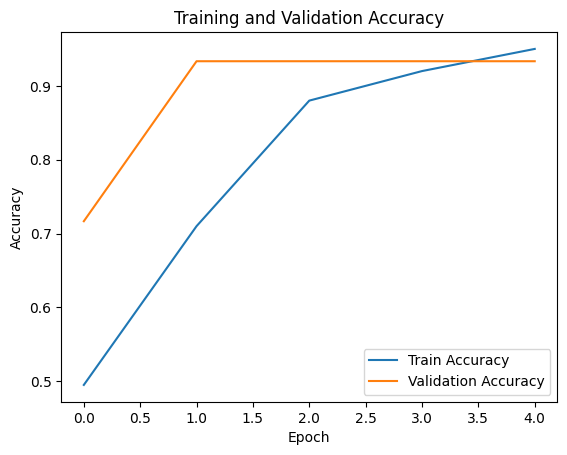

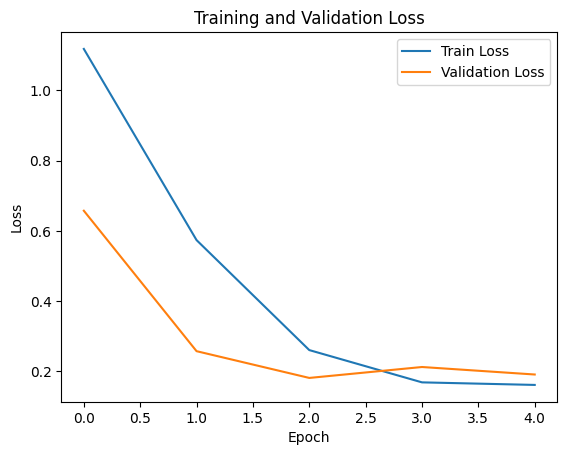

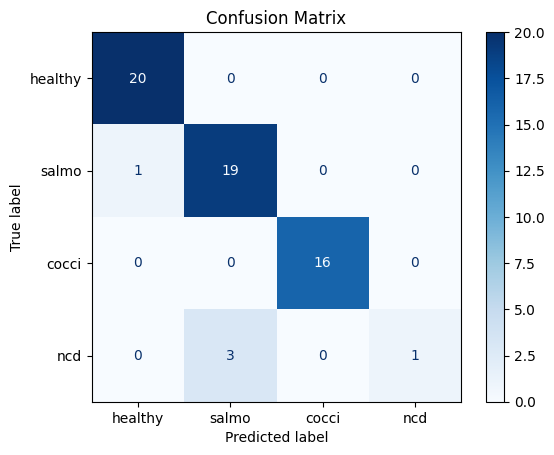

In [18]:
resnet50 = models.resnet50(pretrained=True)

num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Identity()

model = PoultryDiseaseClassifier()
model.to(device)

optimizer = optim.Adam([
    {'params': model.resnet50.parameters(), 'lr': LEARNING_RATE * 0.1},
    {'params': model.dense1.parameters(), 'lr': LEARNING_RATE},
    {'params': model.dropout.parameters(), 'lr': LEARNING_RATE},
    {'params': model.dense2.parameters(), 'lr': LEARNING_RATE}
])

training_history = load_checkpoint(CHECKPOINT_FILENAME, model, optimizer)

train_accuracy_history = training_history['train_accuracy_history']
accuracy_history = training_history['accuracy_history']
train_loss_history = training_history['train_loss_history']
val_loss_history = training_history['val_loss_history']
conf_matrix = training_history['conf_matrix']

plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

if isinstance(conf_matrix, list):
    last_conf_matrix = np.array(conf_matrix[-1])
else:
    last_conf_matrix = np.array(conf_matrix)

disp = ConfusionMatrixDisplay(confusion_matrix=last_conf_matrix, display_labels=CLASS_LIST)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

**Transformaciju atvaizdavimas**

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x791834389090>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x791834389090>self._shutdown_workers()

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1479, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():    self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only test a child process'    
AssertionErrorif w.is_alive():: 
can only test a child process  File "/usr/lib/p

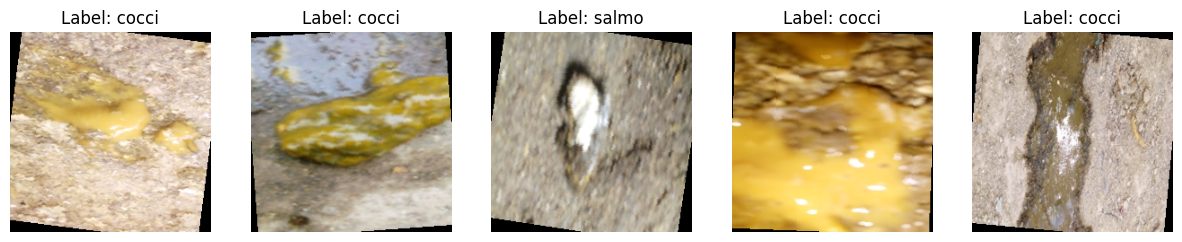

In [26]:
def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    img = img * std + mean
    return img

def imshow(img, title=None):
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()

INDEX_TO_CLASS = {v: k for k, v in CLASS_INDICES.items()}

dataiter = iter(train_loader)
images, labels = next(dataiter)

num_images_to_show = 5
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))
for i in range(num_images_to_show):
    ax = axes[i]
    img = denormalize(images[i], mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    npimg = img.numpy()
    npimg = np.clip(npimg, 0, 1)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    class_index = labels[i].argmax().item()
    class_name = INDEX_TO_CLASS[class_index]
    ax.set_title(f"Label: {class_name}")
    ax.axis('off')
plt.show()
